In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Data

We generate 1 million samples from the Gaussian distribution with the model parameters:
1. <b>delta</b> ~ cauchy(0, 1)
2. <b>mu</b> ~ cauchy(0, 1)
3. <b>sigma</b> ~ gamma(2, 2)
4. <b>alpha</b> = delta * sigma
5. <b>x</b> ~ normal(mu+alpha, sigma)
6. <b>y</b> ~ normal(mu, sigma)

In [76]:
num_points = 1000000     # [100, 10000, 1000000]

In [77]:
def generate_data_normal(N):
    delta = np.random.standard_cauchy(1)
    mu = np.random.standard_cauchy(1)
    sigma = np.random.gamma(2, 2, 1)
    alpha = delta * sigma
    
    xdata = np.random.normal(mu+alpha, sigma, N)
    ydata = np.random.normal(mu, sigma, N)
    return (xdata, ydata)

In [78]:
def plot_data_hist(x, y):
    plt.figure(figsize=(10,5))
    plt.hist(x, alpha=0.5, bins=500, label="X data")
    plt.hist(y, alpha=0.5, bins=500, label="Y data")
    plt.legend(loc='lower right', fontsize=11)
    plt.show()
    
def plot_trace_hist(trace):
    trace = trace[trace < 1]
    plt.hist(trace, alpha=0.5, bins=500, label="delta")
    plt.legend(loc='lower right', fontsize=11)
    plt.show()

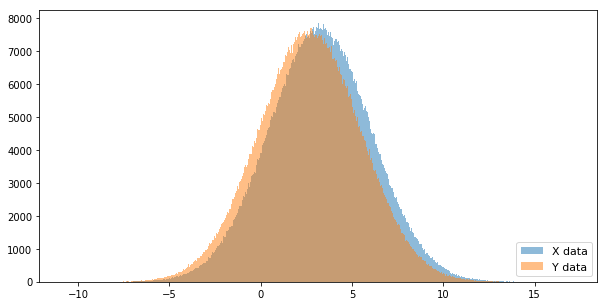

In [79]:
np.random.seed(33)
xdata, ydata = generate_data_normal(num_points)
plot_data_hist(xdata, ydata)

# PyStan

The PyStan project is the official Python wrapper of the Stan Probabilistic programming language, which is implemented in C++.

In [6]:
import pystan
pystan.__version__

'2.15.0.0'

In [7]:
# Create the Stan model
fit_code = """
data {
	int<lower=0> N; 	// number of entities
	real y[N]; 		// normally distributed KPI in the control group
	real x[N]; 		// normally distributed KPI in the treatment group
}

parameters {
	real mu;			// population mean
	real<lower=0> sigma;// population variance
	real delta;
}

transformed parameters {
	real alpha;			// total effect size
	alpha = delta * sigma;
}

model {
	delta ~ cauchy(0, 1);
	mu ~ cauchy(0, 1);
	sigma ~ gamma(2, 2);
	x ~ normal(mu+alpha, sigma);
	y ~ normal(mu, sigma);
}
"""
fit_data = {'N': num_points, 'x': xdata, 'y': ydata}

Sampling in Stan uses a No U-Turn Sampler, which is more sophisticated than classic Metropolis-Hastings or Gibbs sampling.

In [8]:
import time
start_time = time.time()

# perform the fit
fit = pystan.stan(model_code=fit_code, data=fit_data, iter=25000, chains=4)
# extract the traces
traces = fit.extract()
pystan_mcmc_trace = traces['delta']

end_time = time.time()

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_b2d45a7d585903714f857946572d3df0 NOW.


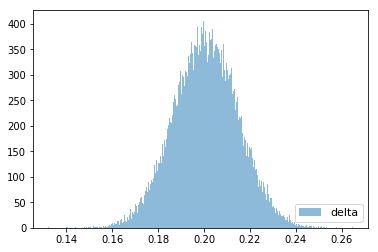

--- pystan mcmc 99.3212342262268 seconds ---


In [9]:
plot_trace_hist(pystan_mcmc_trace)
print("--- pystan mcmc %s seconds ---" % (end_time - start_time))

Variational inference is a scalable technique for approximate Bayesian inference. Variational inference in Stan  implements automatic differentiation variational inference (ADVI). The user only provides a Bayesian model and a dataset; nothing else. The algorithm automatically determines an appropriate variational family and optimizes the variational objective.

In [10]:
from pystan import StanModel
start_time = time.time()

stan_model = StanModel(model_code=fit_code)
results = stan_model.vb(data=fit_data)
pystan_vi_trace = results['sampler_params'][2]

end_time = time.time()

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_b2d45a7d585903714f857946572d3df0 NOW.


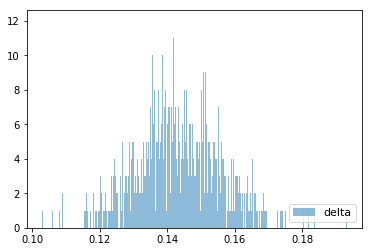

--- pystan vi 67.31382393836975 seconds ---


In [11]:
plot_trace_hist(pystan_vi_trace)
print("--- pystan vi %s seconds ---" % (end_time - start_time))

# PyMC

PyMC by default uses the classic Metropolis-Hastings sampler, one of the earliest MCMC algorithms. For performance, it uses compiled fortran libraries.  

However, here we are using the latest PyMC3, where they also use No U-Turn Sampler as the same as Stan. And PyMC3 uses a native Python complier.

In [28]:
import pymc3 as pymc
pymc.__version__

'3.1'

In [ ]:
import time
start_time = time.time()

with pymc.Model() as model:
    delta = pymc.Cauchy('delta', 0, 1)
    mu = pymc.Cauchy('mu', 0, 1)
    sigma = pymc.Gamma('sigma', 2, 2)
    alpha = pymc.Deterministic('alpha', delta * sigma)
    x = pymc.Normal('x', mu=mu+alpha, sd=sigma, observed=xdata)
    y = pymc.Normal('y', mu=mu, sd=sigma, observed=ydata)
    
    # run the basic MCMC: we'll do 25000 iterations to match PyStan above
    trace = pymc.sample(25000, tune=500)
    pymc_trace = trace['delta']

end_time = time.time()

INFO:pymc3:Auto-assigning NUTS sampler...
INFO:pymc3:Initializing NUTS using ADVI...
Average Loss = 4.9248e+06:   7%|▋         | 14699/200000 [09:30<2:04:00, 24.91it/s]
INFO:pymc3.variational.inference:Convergence archived at 14700
INFO:pymc3.variational.inference:Interrupted at 14,700 [7%]: Average Loss = 8.5849e+06
  3%|▎         | 796/25500 [04:43<2:18:14,  2.98it/s]

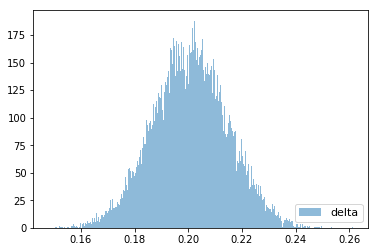

--- pymc3 mcmc 77.31083488464355 seconds ---


In [69]:
plot_trace_hist(pymc_trace)
print("--- pymc3 mcmc %s seconds ---" % (end_time - start_time))

Variational inference in PyMC3 implements the same algorithm as in Stan --- automatic differentiation variational inference (ADVI).

Average Loss = 50,847: 100%|██████████| 10000/10000 [00:02<00:00, 3633.90it/s]   
INFO:pymc3.variational.inference:Finished [100%]: Average Loss = 50,845


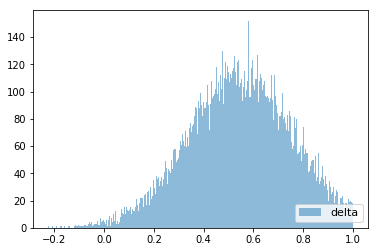

--- pymc3 vi 6.337280035018921 seconds ---


In [80]:
import time
start_time = time.time()

with model:
    mean_field = pymc.fit(method='advi')
    trace = mean_field.sample(25000)
    pymc_trace = trace['delta']
    
end_time = time.time()

plot_trace_hist(pymc_trace)
print("--- pymc3 vi %s seconds ---" % (end_time - start_time))

Notice that ADVI will to approximate the multimodal distribution, since it uses a Gaussian distribution that has a single mode.

# Runtime Comparison

|         |         |100 data|10k data|1m data|
|-------  | ------- | ------:| ------:| -----:|
| PyStan  | Sampling| 64s    | 89s    |3146s (~50 mins)|
| PyStan  | VI      | 62s    | 62s    | 80s   |
| PyMC3   | Sampling| 32s    | 76s    | over 2 hours      |
| PyMC3   | VI      |  5s    |  6s    | 6s    |                        